In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import torch
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16, VGG, VGG16_Weights
from torchvision import transforms
from scipy import ndimage
from PIL import Image as pil
import numpy as np
from tqdm.notebook import tqdm
import ast
import cv2

In [4]:
class UnNormalize(transforms.Normalize):
    def __init__(self,mean,std,*args,**kwargs):
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model = model.to(DEVICE)

In [8]:
model_conv_modules = [m for m in list(model.features) if type(m) is torch.nn.modules.conv.Conv2d]

In [9]:
model_conv_modules

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [10]:
model_modules = [m for m in list(model.features)]

In [11]:
[(i,m) for i,m in enumerate(model_modules)]

[(0, Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (1, ReLU(inplace=True)),
 (2, Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (3, ReLU(inplace=True)),
 (4,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (5, Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (6, ReLU(inplace=True)),
 (7, Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (8, ReLU(inplace=True)),
 (9,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (10, Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (11, ReLU(inplace=True)),
 (12, Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (13, ReLU(inplace=True)),
 (14, Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (15, ReLU(inplace=True)),
 (16,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (17, Conv2d(256, 512, kernel_size=(3, 3

In [12]:
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
normalize_imagenet_inv = UnNormalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

Старт оптимизации начнем с некоторого рандомного изображения

In [13]:
input_img = np.random.randn(224, 224, 3)
min_img = input_img.min(axis=0, keepdims=True).min(axis=1, keepdims=True)
max_img = input_img.max(axis=0, keepdims=True).max(axis=1, keepdims=True)
input_img = (255*(input_img-min_img)/(max_img-min_img)).astype(np.uint8)

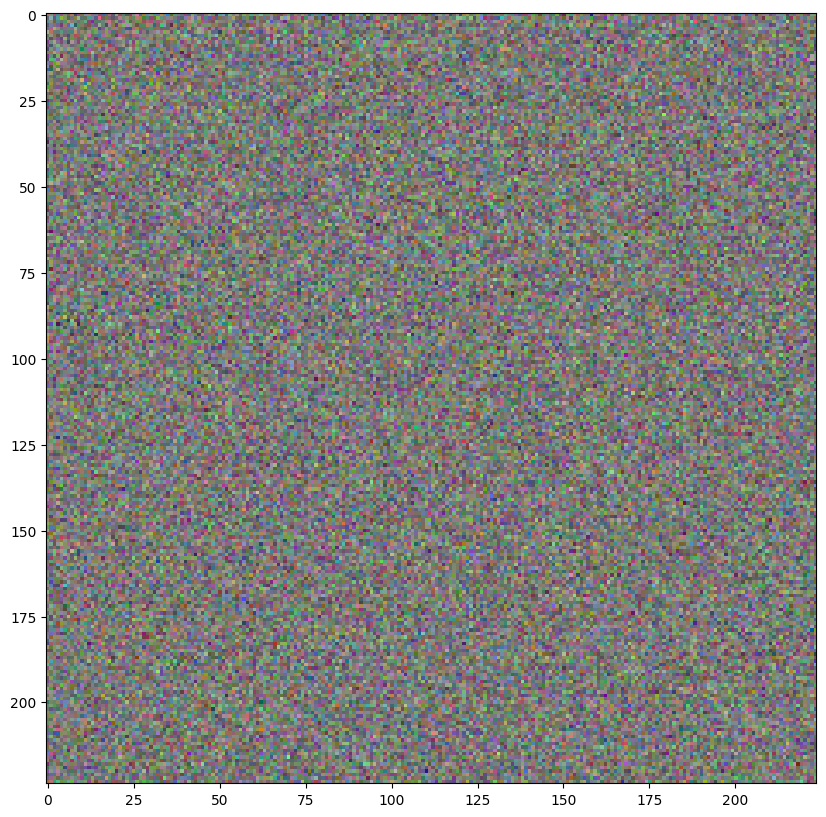

In [14]:
plt.imshow(input_img)

In [15]:
def make_torch_tensor_imagenet_normalized(img_np_float):
    x = transforms.ToPILImage()(img_np_float)
    x = transforms.ToTensor()(x)
    x = normalize_imagenet(x)
    x = torch.unsqueeze(x, 0)
    return x

In [16]:
def transform_back(img_tensor):
    x = torch.squeeze(img_tensor)
    x = normalize_imagenet_inv(x)
    x = x.detach().cpu().numpy()
    x = np.transpose(x, (1,2,0))
    x = (255*(x-x.min())/(x.max()-x.min())).astype(np.uint8)
    return x

In [17]:
input_img_tensor = make_torch_tensor_imagenet_normalized(input_img)

In [18]:
input_img_tensor = input_img_tensor.to(DEVICE)

обязательно укажем `pytorch` вычислять градиенты по этому тензору

In [19]:
input_img_tensor = input_img_tensor.requires_grad_(True)

In [20]:
input_img_tensor.shape

torch.Size([1, 3, 224, 224])

In [21]:
layer_num = 17
feature_num = 42
icoord = 14
jcoord = 2

In [22]:
submodel = torch.nn.Sequential(*list(model.features)[:(layer_num+1)])

In [23]:
submodel

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Прототипируем вычисления. Ниже мы их будет проводить итерационно, в цикле максимизации нужного нам признака.

In [32]:
hidden_features = submodel(input_img_tensor)

In [33]:
hidden_features.shape

torch.Size([1, 512, 28, 28])

In [34]:
f1 = hidden_features[0,feature_num,:,:]

Средствами `pytorch` мы можем безболезненно считать градиенты только для скаляров. Поэтому сделаем из полученного признака скаляр - хотя бы осреднением.

In [35]:
f1 = torch.mean(f1)

In [36]:
f1.backward()

In [37]:
input_img_tensor.grad

tensor([[[[ 2.1308e-04,  1.6017e-04,  1.3770e-04,  ...,  1.9500e-03,
            6.0189e-04,  9.8857e-05],
          [ 1.1976e-03,  8.5966e-04,  1.2290e-03,  ...,  1.5499e-03,
            1.7913e-03, -3.3859e-04],
          [-6.1634e-04, -3.3286e-04, -9.2225e-04,  ...,  1.7547e-03,
            1.2466e-03,  4.1192e-04],
          ...,
          [ 2.3959e-03,  3.2439e-03,  9.5492e-04,  ..., -1.2727e-04,
           -1.0467e-04, -6.4058e-04],
          [ 6.3231e-04, -4.8667e-04, -1.0523e-03,  ..., -5.7386e-04,
            1.1052e-03,  2.4057e-04],
          [ 8.3613e-05, -7.3733e-04,  8.3939e-06,  ...,  9.5457e-04,
           -6.7169e-05, -1.0129e-04]],

         [[-2.4117e-04, -4.6419e-04,  3.1928e-04,  ...,  7.7815e-04,
           -5.1170e-04, -4.1685e-04],
          [ 1.3977e-03,  8.6087e-04,  2.0530e-03,  ..., -2.2713e-03,
           -8.7389e-04, -1.6606e-03],
          [-4.5514e-04,  7.9947e-04,  1.5650e-03,  ...,  2.9314e-04,
           -7.7777e-04, -3.1942e-04],
          ...,
     

In [38]:
input_img_tensor.grad = -input_img_tensor.grad

In [39]:
input_img_tensor.grad

tensor([[[[-2.1308e-04, -1.6017e-04, -1.3770e-04,  ..., -1.9500e-03,
           -6.0189e-04, -9.8857e-05],
          [-1.1976e-03, -8.5966e-04, -1.2290e-03,  ..., -1.5499e-03,
           -1.7913e-03,  3.3859e-04],
          [ 6.1634e-04,  3.3286e-04,  9.2225e-04,  ..., -1.7547e-03,
           -1.2466e-03, -4.1192e-04],
          ...,
          [-2.3959e-03, -3.2439e-03, -9.5492e-04,  ...,  1.2727e-04,
            1.0467e-04,  6.4058e-04],
          [-6.3231e-04,  4.8667e-04,  1.0523e-03,  ...,  5.7386e-04,
           -1.1052e-03, -2.4057e-04],
          [-8.3613e-05,  7.3733e-04, -8.3939e-06,  ..., -9.5457e-04,
            6.7169e-05,  1.0129e-04]],

         [[ 2.4117e-04,  4.6419e-04, -3.1928e-04,  ..., -7.7815e-04,
            5.1170e-04,  4.1685e-04],
          [-1.3977e-03, -8.6087e-04, -2.0530e-03,  ...,  2.2713e-03,
            8.7389e-04,  1.6606e-03],
          [ 4.5514e-04, -7.9947e-04, -1.5650e-03,  ..., -2.9314e-04,
            7.7777e-04,  3.1942e-04],
          ...,
     

In [40]:
opt = torch.optim.Adam([input_img_tensor], lr=0.5)

In [41]:
objective_history = []
input_snapshots = []

In [42]:
steps = 10000
snapshot_each = 50

In [43]:
# Вариант для карт активации ранга более чем 2

with tqdm(total=steps) as pbar:
    for i in range(steps):
        features = submodel(input_img_tensor)
        f1 = features[0,feature_num,:,:]
#         f2 = features[0,feature_num,icoord,jcoord]
        f1 = torch.mean(f1)
        
        f1_np = float(f1.detach().cpu().numpy())
        objective_history.append(f1_np)
        f1.backward()
        input_img_tensor.grad = -input_img_tensor.grad
        opt.step()
        
        if i % snapshot_each == 0:
            input_snapshots.append(transform_back(input_img_tensor))
        
        opt.zero_grad()
        pbar.update(1)
        pbar.set_postfix({'step': i, 'f1_mean': f1_np})

  0%|          | 0/10000 [00:00<?, ?it/s]

In [44]:
for idx,img in tqdm(enumerate(input_snapshots), total=len(input_snapshots)):
    fn = './4gif/%04d.png'%idx
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(fn, img)

  0%|          | 0/200 [00:00<?, ?it/s]

In [45]:
!ffmpeg -f image2 -framerate 1 -i ./4gif/00%02d.png optimization.gif

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

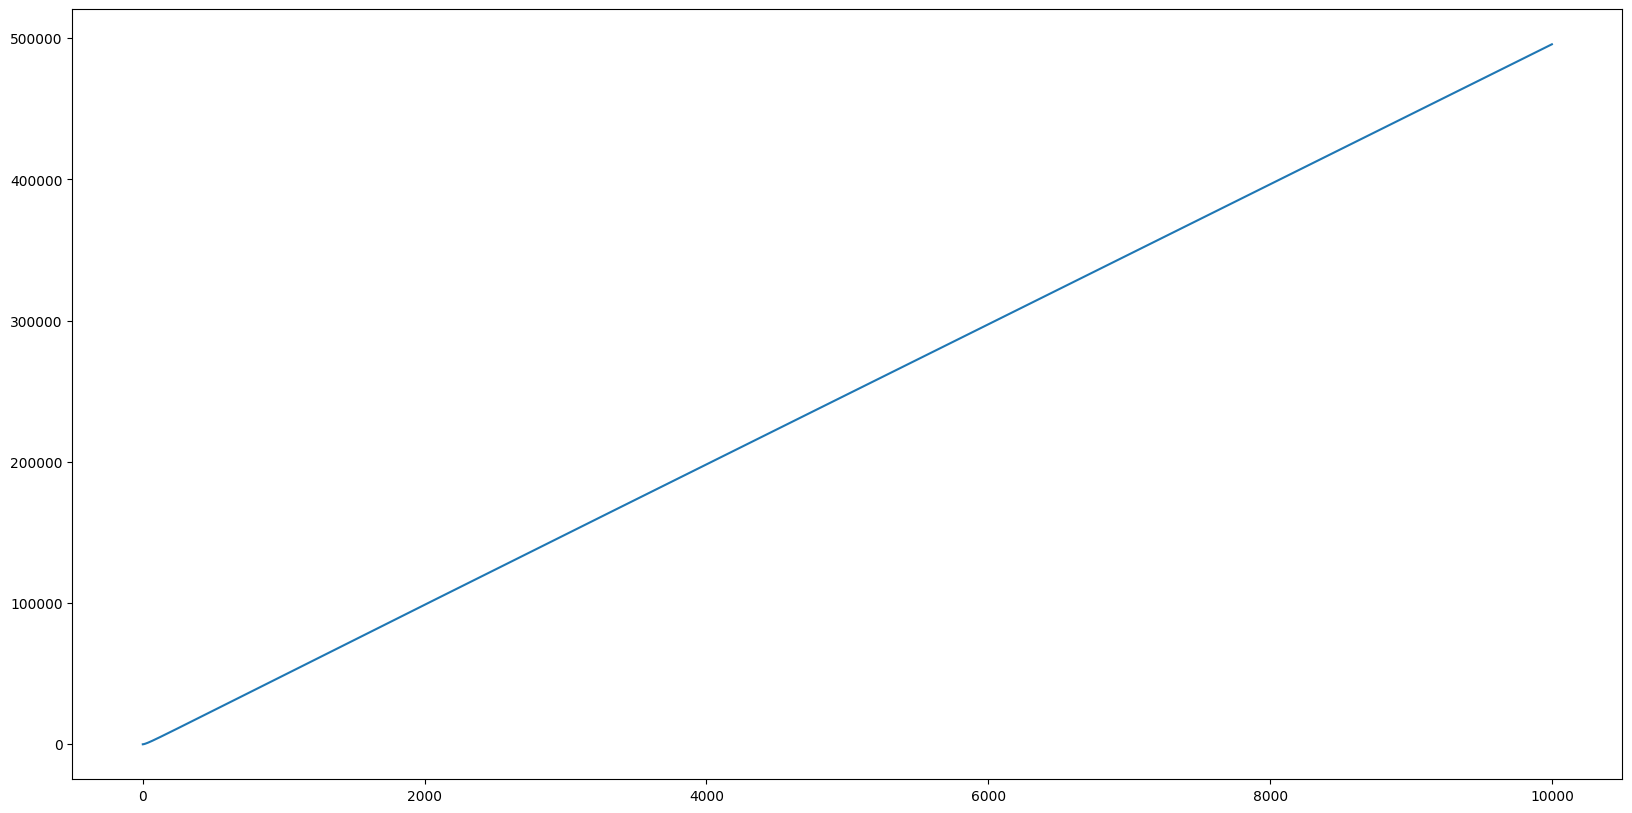

In [46]:
plt.plot(objective_history)

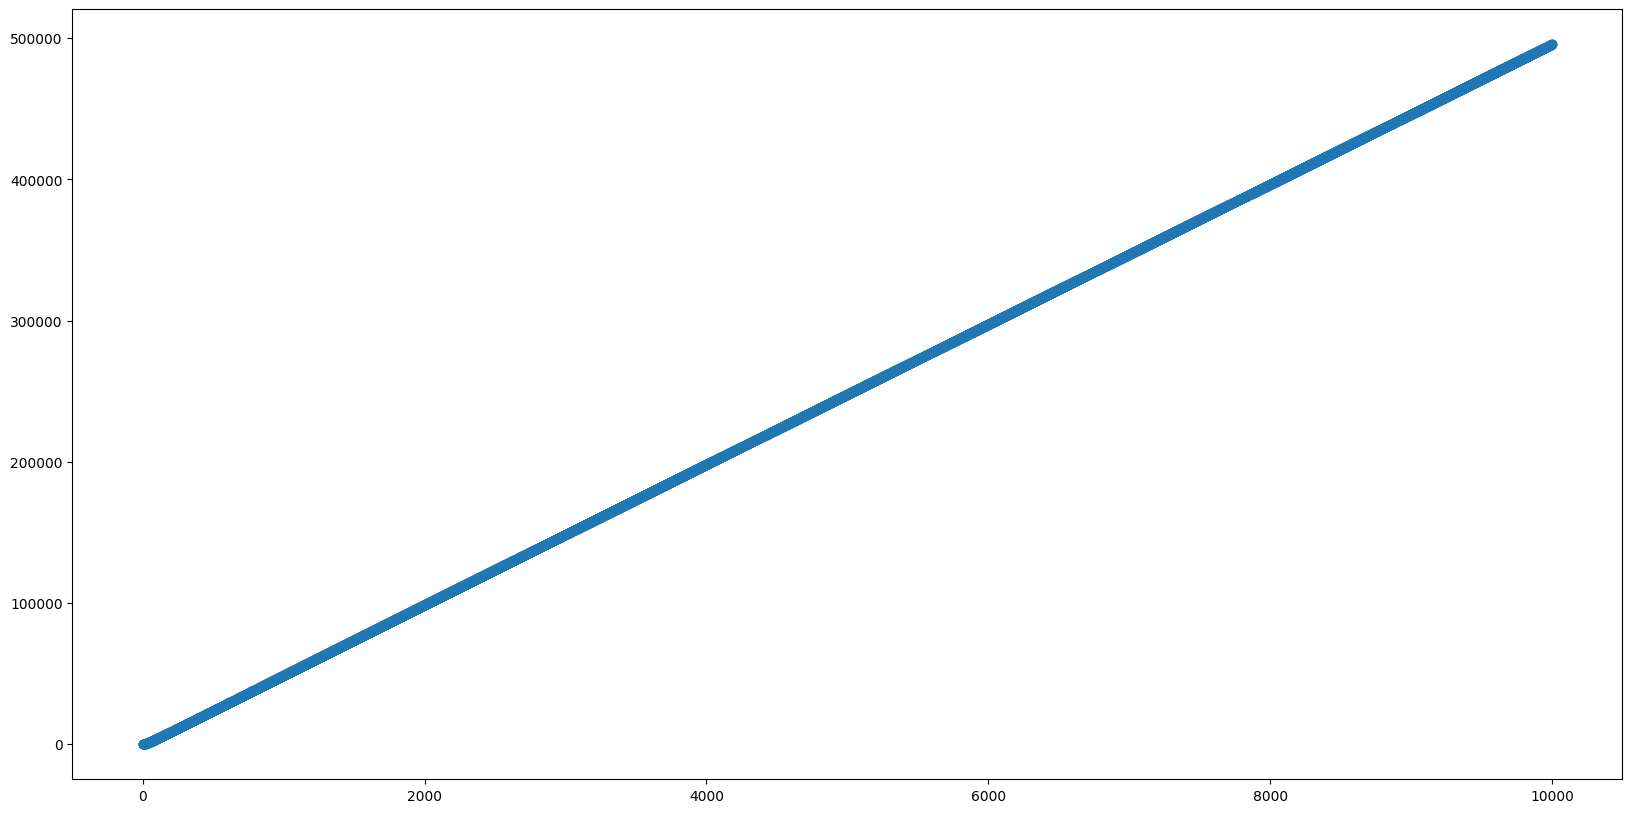

In [47]:
plt.scatter(np.arange(len(objective_history)), objective_history)

In [48]:
x = transform_back(input_img_tensor)

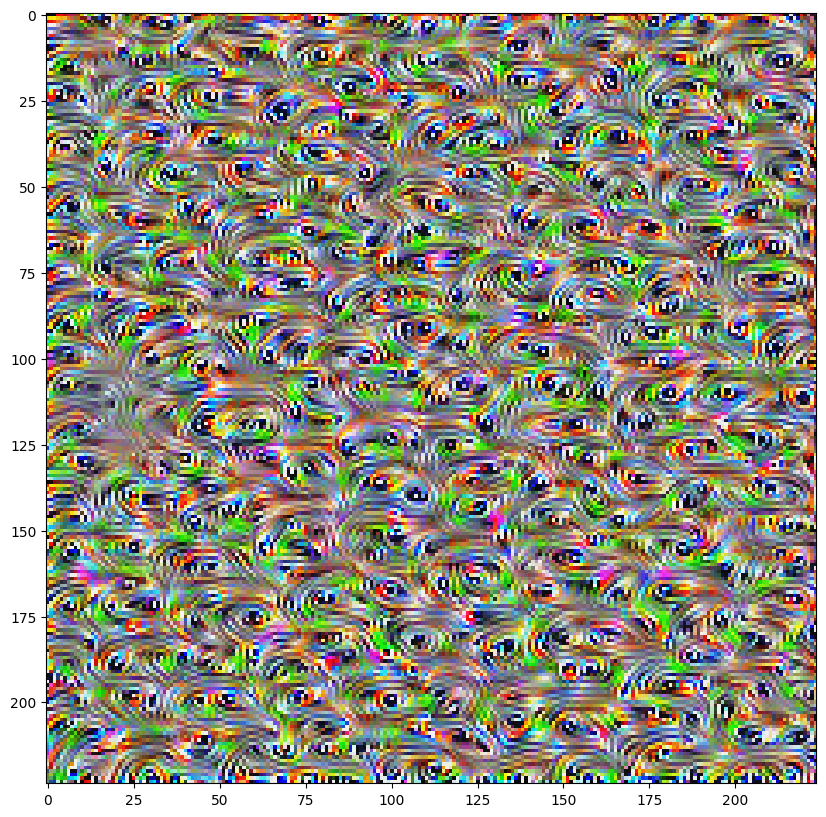

In [49]:
plt.imshow(x)